In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, losses
# import tensorflow as tf

import seaborn as sns

In [3]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [15]:
def display_mode_trainTestGraphs(results):
    train_loss = results.history['loss']
    train_acc = results.history['accuracy']
    val_loss = results.history['val_loss']
    val_acc = results.history['val_accuracy']


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=results.epoch, y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=results.epoch, y=train_acc, ax=ax2, label='train_accuracy')

    sns.lineplot(x=results.epoch, y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=results.epoch, y=val_acc, ax=ax2, label='val_accuracy')
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')
    ax1.legend();

# Training Set

In [4]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [5]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


# Test Set

In [6]:
# Normalizing data for 8 bit
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'images/test/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 1793 images belonging to 8 classes.


# Modeling

## Model 1

In [12]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 64)      

In [13]:
results = model.fit(train_generator,
                    steps_per_epoch=50,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=50,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
50/50 [==============================] - 8s 148ms/step - loss: 0.8560 - accuracy: 0.7994 - val_loss: 0.8312 - val_accuracy: 0.7920
Epoch 2/50
50/50 [==============================] - 7s 147ms/step - loss: 0.7373 - accuracy: 0.8153 - val_loss: 0.8959 - val_accuracy: 0.7823
Epoch 3/50
50/50 [==============================] - 7s 147ms/step - loss: 0.6763 - accuracy: 0.8195 - val_loss: 0.8843 - val_accuracy: 0.7808
Epoch 4/50
50/50 [==============================] - 7s 147ms/step - loss: 0.6085 - accuracy: 0.8355 - val_loss: 0.8126 - val_accuracy: 0.7934
Epoch 5/50
50/50 [==============================] - 7s 147ms/step - loss: 0.5856 - accuracy: 0.8322 - val_loss: 0.7894 - val_accuracy: 0.7897
Epoch 6/50
50/50 [==============================] - 7s 145ms/step - loss: 0.5320 - accuracy: 0.8487 - val_loss: 0.7275 - val_accuracy: 0.7908
Epoch 7/50
50/50 [==============================] - 7s 146ms/step - loss: 0.5712 - accuracy: 0.8384 - val_loss: 0.7244 - val_accuracy: 0.7964
Epoch 

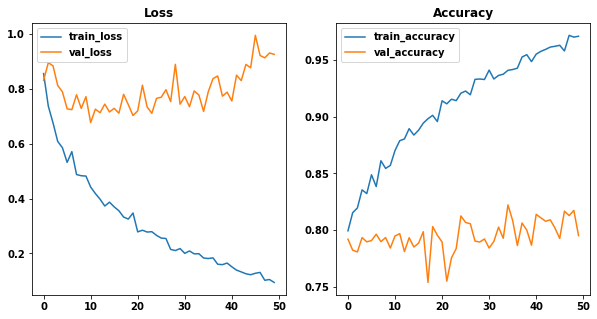

In [16]:
display_mode_trainTestGraphs(results)

## Model 2

Increasing steps in epoch

In [21]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))


model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=losses.CategoricalCrossentropy(),
              metrics=['accuracy'])


model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 64)      

In [22]:
results = model.fit(train_generator,
                    steps_per_epoch=150,  # Number of training samples to pull per epoch
                    epochs=50,  # Number of epochs
                    validation_data=val_generator,
                    validation_steps=100,  # Number of validation samples to run validation on
                    verbose=1
                    )

Epoch 1/50
150/150 [==============================] - 19s 125ms/step - loss: 0.7516 - accuracy: 0.8124 - val_loss: 0.8139 - val_accuracy: 0.7907
Epoch 2/50
150/150 [==============================] - 19s 123ms/step - loss: 0.6123 - accuracy: 0.8271 - val_loss: 0.7553 - val_accuracy: 0.7944
Epoch 3/50
150/150 [==============================] - 19s 124ms/step - loss: 0.5059 - accuracy: 0.8521 - val_loss: 0.7357 - val_accuracy: 0.7974
Epoch 4/50
150/150 [==============================] - 19s 125ms/step - loss: 0.4544 - accuracy: 0.8661 - val_loss: 0.7237 - val_accuracy: 0.7930
Epoch 5/50
150/150 [==============================] - 19s 124ms/step - loss: 0.3908 - accuracy: 0.8834 - val_loss: 0.7014 - val_accuracy: 0.8094
Epoch 6/50
150/150 [==============================] - 19s 124ms/step - loss: 0.3593 - accuracy: 0.8910 - val_loss: 0.6860 - val_accuracy: 0.7900
Epoch 7/50
150/150 [==============================] - 19s 124ms/step - loss: 0.3152 - accuracy: 0.9016 - val_loss: 0.7463 - val_ac

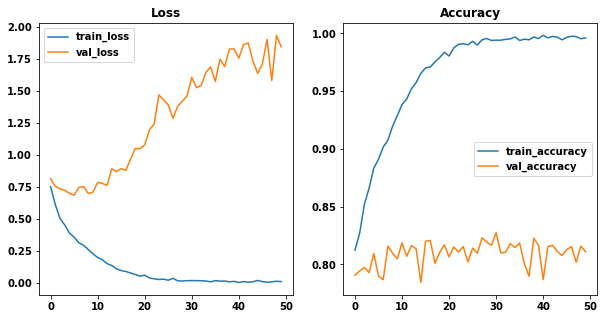

In [23]:
display_mode_trainTestGraphs(results)